## Generalized Random Forest Module: Use Cases and Examples

Causal Forests and [Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf) are a flexible method for estimating treatment effect heterogeneity with Random Forests. The `econml.grf` module implements a high-performance Cython version of the [`grf`](https://github.com/grf-labs/grf) R-package, with support for CausalForests, IVForests and RegressionForests. The module provides estimators that adhere to the scikit-learn fit and predict API, as well as providing methods for uncertainty quantification and confidence intervals.

Within the EconML SDK we use these estimators as final models for CATE estimation, such as in the case of `econml.dml.CausalForestDML`, where we combine a Causal Forest with Double Machine Learning, to residualize the treatment and outcome and call the `econml.grf.CausalForest` on the residuals. Similarly, the `econml.dr.ForestDRLearner` uses an `econml.grf.RegressionForest` as a final stage estimator on the doubly robust targets estimated by the first stage. The estimators here should primarily be used in conjunction with CateEstimators and not as standalone, but we provide here examples of their direct usage functionality.

The EconML SDK implements the following Generalized Random Forest variants:

* `CausalForest`: suitable for many continuous or discrete treatments, when there is no unobserved confounding

* `CausalIVForest`: suitable for many continuous or discrete treatments, when there is unobserved confounding and access to an instrument

* `RegressionForest`: an analogue of `sklearn.ensemble.RandomForestRegressor`, but with support for confidence intervals.

If you also have multiple outcomes, then the class `econml.grf.MultiOutputGRF`, is a wrapper class that wraps any generalized random forest and enables support for multiple outcomes by fitting a separate forest for each target outcome.

Our estimators provide support for the heterogeneity criterion as outlined in [Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf), using `criterion='het'`, as well as a mean squared error criterion that penalizes high-variance splits, using `criterion='mse'`.[Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf).

Uncertainty quantification and confidence intervals is computed via the Bootstrap-of-Little-Bags approach outlined in [Generalized Random Forests](https://arxiv.org/pdf/1610.01271.pdf).

The tree data structure that is used to store each tree is compatible with `sklearn.tree._tree.Tree` and so scikit-learn functionalities on trees can be applied to our trained trees (e.g. tree plotting).

In [1]:
from econml.grf import CausalForest, CausalIVForest, RegressionForest
from econml.dml import CausalForestDML
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

### 1. Causal Forest : Heterogeneous Causal effects with no unobserved confounders

In [2]:
np.random.seed(42)
n_samples = 2000
n_features = 10
n_treatments = 1

def true_te(X) :
    return np.hstack(
        [
            (X[:, [0]] > 0) * X[:, [0]],
            np.ones((X.shape[0], n_treatments - 1)) * np.arange(1, n_treatments).reshape(1, -1)
        ]
    )

In [3]:
X = np.random.normal(0, 1, size = (n_samples, n_features))
T = np.random.normal(0, 1, size = (n_samples, n_treatments))

In [4]:
for t in range(n_treatments) :
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))

In [5]:
y = np.sum(
    true_te(T) * T, 
    axis = 1,
    keepdims = True
) + np.random.normal(0, 0.5, size = (n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [6]:
causal_forest = CausalForest(
    criterion = 'het',
    n_estimators = 400,
    min_samples_leaf = 5,
    max_depth = None,
    min_var_fraction_leaf = None, 
    min_var_leaf_on_val = True,
    min_impurity_decrease = 0,
    max_samples = 0.45,
    min_balancedness_tol = 0.45,
    warm_start = False,
    inference = True,
    fit_intercept = True,
    subforest_size = 4,
    honest = True,
    verbose = 0,
    n_jobs = -1,
    random_state = 42
)

In [7]:
causal_forest.fit(
    X = X, T = T, y = y
)

CausalForest(criterion='het', min_impurity_decrease=0, min_var_leaf_on_val=True,
             n_estimators=400, random_state=42)

In [8]:
point, lb, ub = causal_forest.predict(X_test, interval = True, alpha = 0.01)

In [9]:
point = causal_forest.predict(X_test)

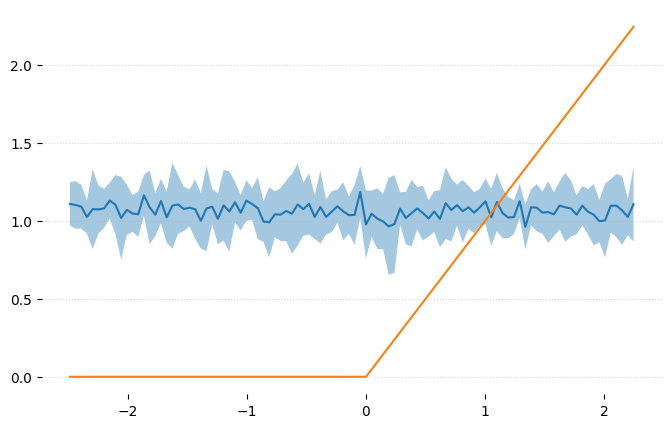

In [10]:
fig, ax = plt.subplots(figsize = (8, 5))
for t in range(n_treatments) :
    ax.plot(X_test[:, 0], point[:, t])
    if causal_forest.inference :
        ax.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha = 0.4)
    ax.plot(X_test[:, 0], true_te(X_test)[:, t])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.show()

In [11]:
X

array([[ 0.49671415, -0.1382643 ,  0.64768854, ...,  0.76743473,
        -0.46947439,  0.54256004],
       [-0.46341769, -0.46572975,  0.24196227, ...,  0.31424733,
        -0.90802408, -1.4123037 ],
       [ 1.46564877, -0.2257763 ,  0.0675282 , ...,  0.37569802,
        -0.60063869, -0.29169375],
       ...,
       [ 1.08518892, -0.38458244, -0.88114131, ..., -1.03302885,
         0.71373522,  0.32797039],
       [ 0.96259198,  0.51259951, -0.75311158, ..., -0.68072161,
         2.03658236, -0.41274409],
       [ 1.23286679, -0.46866051,  0.88883882, ...,  0.37835397,
         1.71352973, -1.6199198 ]])

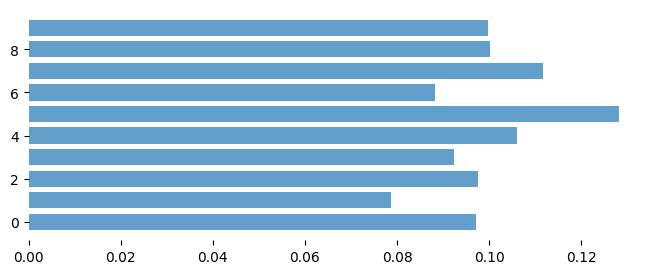

In [12]:
fig, ax = plt.subplots(figsize = (8, 3))
ax.barh(
    range(10),
    causal_forest.feature_importances(max_depth = 4, depth_decay_exponent = 2.0),
    alpha = 0.7,
    height = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.show()

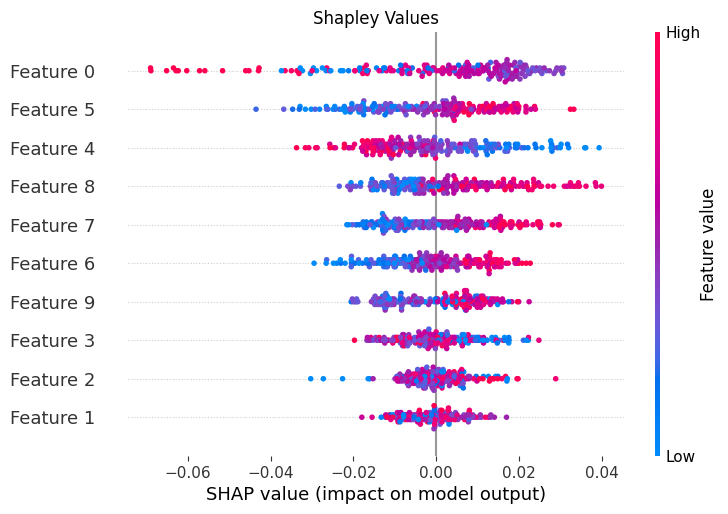

In [13]:
import shap
explainer = shap.Explainer(causal_forest, shap.maskers.Independent(X, max_samples = 100))
shap_values = explainer(X[:200])
shap.plots.beeswarm(shap_values, show = False)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Shapley Values')
plt.show()

In [14]:
causal_forest.decision_path(X_test[:1])

(<1x47638 sparse matrix of type '<class 'numpy.int64'>'
 	with 3408 stored elements in Compressed Sparse Row format>,
 array([    0,   121,   250,   365,   492,   607,   730,   839,   962,
         1079,  1206,  1327,  1440,  1559,  1678,  1797,  1916,  2031,
         2150,  2269,  2394,  2509,  2628,  2747,  2868,  2993,  3110,
         3233,  3342,  3471,  3590,  3707,  3824,  3951,  4072,  4191,
         4316,  4439,  4556,  4675,  4790,  4905,  5026,  5137,  5250,
         5381,  5510,  5633,  5752,  5873,  5994,  6113,  6234,  6359,
         6472,  6597,  6716,  6833,  6954,  7079,  7196,  7313,  7432,
         7559,  7676,  7799,  7916,  8035,  8158,  8279,  8398,  8507,
         8628,  8741,  8862,  8981,  9098,  9215,  9344,  9467,  9586,
         9711,  9836,  9947, 10066, 10185, 10310, 10429, 10552, 10667,
        10792, 10911, 11026, 11147, 11264, 11379, 11492, 11619, 11738,
        11861, 11978, 12097, 12218, 12337, 12462, 12583, 12698, 12817,
        12942, 13071, 13190, 1

In [15]:
print(causal_forest.apply(X_test[:1]))

[[102 117  53 115  78 108  93  19  96  49  41  48  69 105  85  42 111  84
   90  64  51  60  55  36 100  70 121  44  53  53  89  64  76 107  81 120
   54  95  59  90 114 100  71 111 126  58 111  56 108 112  84 108 123  82
   30  82 100  90  83  55  56 116 122 113 102 102 114 101 109  58  24  41
   43  91 103 113  31 123 105  64  71  84  70  88  24 106  92 108  41 104
   60 110  95  77 103  71  97 111  36  37  52  47 110  76  87  85  93 102
  109  54  57  69 107  86  22  42  33  95  96  62  68  70   6  12 111 117
  101  46  86  82 112  83 116  96  98  83  21 103 115 114  27  82 101  50
   29  89 114   5 108  52  38 101 117  69 107  48 116  55  76  16  92  82
   37  55 107  65  78  28  87 118  59  88 100  93  59  52  92  96  76  53
   25 106 115  95  17 101   5  75  97 118  37 116  49  76  52  82  93  21
   43  27  29  63  89  28 116  67  18   9  28  98  73   7  66  11 113 102
   84 113  12   3 109  76  41  43  95  39   7  22  68  90   5  41 113 111
  117 109  65  32  73 119  11   3  78 

### 2. Causal IV Forest : Heterogeneous causal effects with unobserved confounders

In [16]:
np.random.seed(42)
n_samples = 2000
n_features = 10
n_treatments = 2
def true_te(X):
    return np.hstack([X[:, [0]] > 0, np.ones((X.shape[0], n_treatments - 1))])

In [17]:
Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, .2, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]

In [18]:
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 10 * U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [19]:
causal_iv_forest = CausalIVForest(
    criterion = 'mse',
    n_estimators = 400,
    min_samples_leaf = 40,
    min_var_fraction_leaf = 0.1,
    min_var_leaf_on_val = True,
    min_impurity_decrease = 0.001,
    max_samples = 0.45,
    max_depth = None,
    warm_start = False,
    inference = True,
    subforest_size = 4,
    honest = True,
    verbose = 0,
    n_jobs = -1,
    random_state = 42
)

In [20]:
causal_iv_forest.fit(X = X, T = T, y = y, Z = Z)

CausalIVForest(min_impurity_decrease=0.001, min_samples_leaf=40,
               min_var_fraction_leaf=0.1, min_var_leaf_on_val=True,
               n_estimators=400, random_state=42)

In [21]:
point, lb, ub = causal_iv_forest.predict(X_test, interval = True, alpha = 0.01)

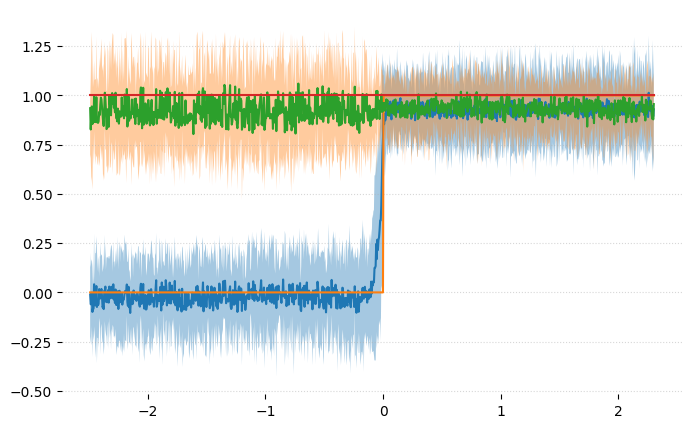

In [22]:
fig, ax = plt.subplots(figsize = (8, 5))
for t in range(n_treatments) :
    ax.plot(X_test[:, 0], point[:, t])
    if causal_forest.inference :
        ax.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha = 0.4)
    ax.plot(X_test[:, 0], true_te(X_test)[:, t])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.show()

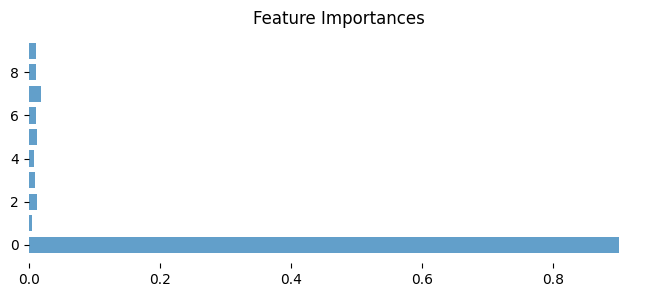

In [23]:
fig, ax = plt.subplots(figsize = (8, 3))
ax.barh(
    range(10),
    causal_iv_forest.feature_importances(max_depth = 4, depth_decay_exponent = 2.0),
    alpha = 0.7,
    height = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.title('Feature Importances')
plt.show()

In [24]:
explainer = shap.Explainer(causal_iv_forest, shap.maskers.Independent(X, max_samples = 100))
shap_values = explainer(X[:200])

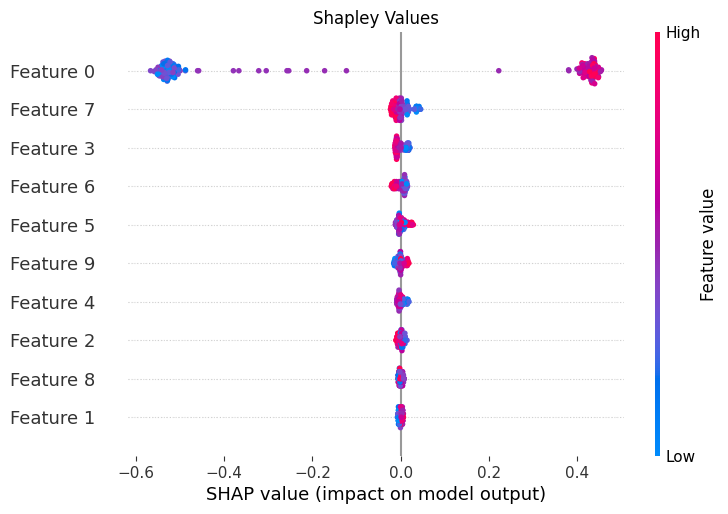

In [25]:
shap.plots.beeswarm(shap_values[:, :, 0], show = False)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Shapley Values')
plt.show()

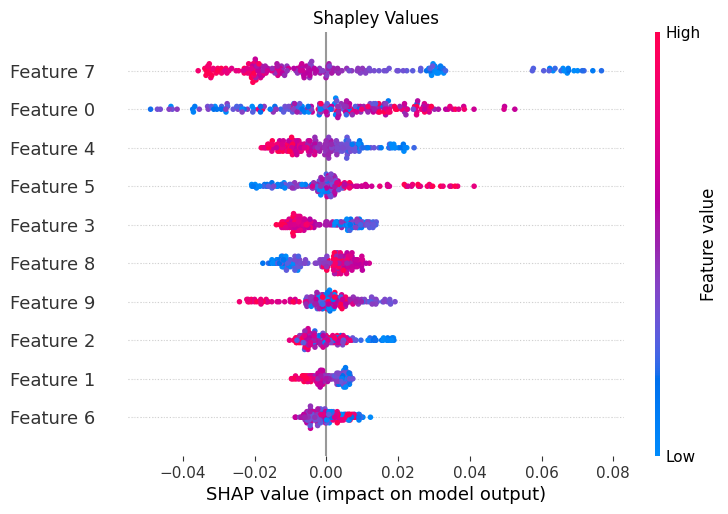

In [26]:
shap.plots.beeswarm(shap_values[:, :, 1], show = False)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Shapley Values')
plt.show()

In [27]:
causal_iv_forest[0].decision_path(X_test[:1])

<1x15 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [28]:
causal_iv_forest[0].apply(X_test[:1])

array([6])

### 3. Regression Forest : Random Forest Regressor with Confidence intervals

In [29]:
np.random.seed(42)
n_samples = 2000
n_features = 10
n_outputs = 2
def true_te(X):
    return np.hstack([X[:, [0]] ** 2 + 1, np.ones((X.shape[0], n_outputs - 1))])

In [30]:
X = np.random.normal(0, 1, size=(n_samples, n_features))
y = true_te(X) + 0.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [31]:
reg_forest = RegressionForest(
    n_estimators = 400,
    min_samples_leaf = 5,
    max_depth = None,
    min_impurity_decrease = 0.0,
    max_samples = 0.45,
    min_balancedness_tol = 0.45,
    warm_start = False,
    inference = True,
    subforest_size = 4,
    honest = True,
    verbose = 0,
    n_jobs = -1,
    random_state = 42
)

In [32]:
reg_forest.fit(X = X, y = y)

RegressionForest(n_estimators=400, random_state=42)

In [33]:
point, lb, ub = reg_forest.predict(
    X_test, 
    interval = True,
    alpha = 0.01
)

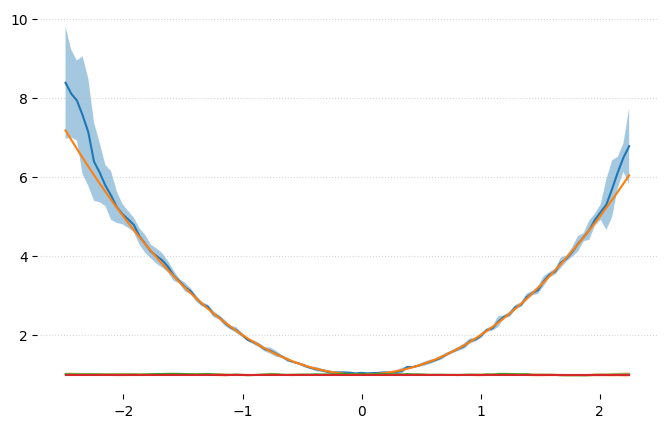

In [34]:
fig, ax = plt.subplots(figsize = (8, 5))
for t in range(n_treatments) :
    ax.plot(X_test[:, 0], point[:, t])
    if causal_forest.inference :
        ax.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha = 0.4)
    ax.plot(X_test[:, 0], true_te(X_test)[:, t])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.show()

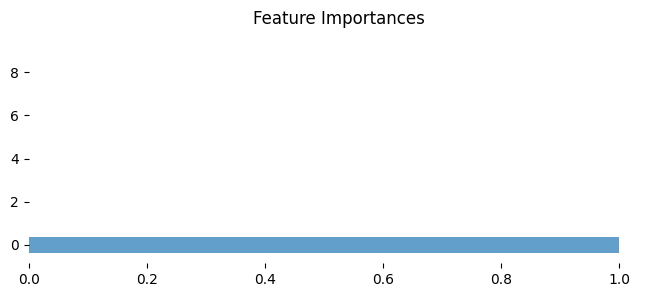

In [35]:
fig, ax = plt.subplots(figsize = (8, 3))
ax.barh(
    range(10),
    reg_forest.feature_importances(max_depth = 4, depth_decay_exponent = 2.0),
    alpha = 0.7,
    height = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
plt.title('Feature Importances')
plt.show()

In [36]:
explainer = shap.Explainer(reg_forest, shap.maskers.Independent(X, max_samples = 100))
shap_values = explainer(X[:200])

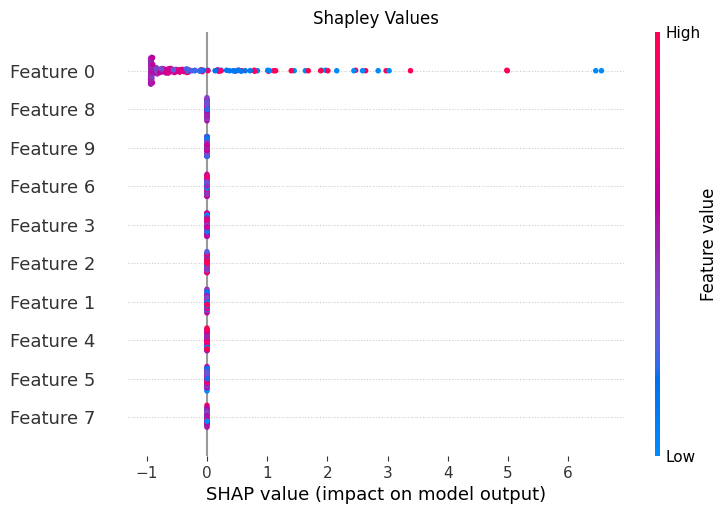

In [37]:
shap.plots.beeswarm(shap_values[:, :, 0], show = False)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Shapley Values')
plt.show()

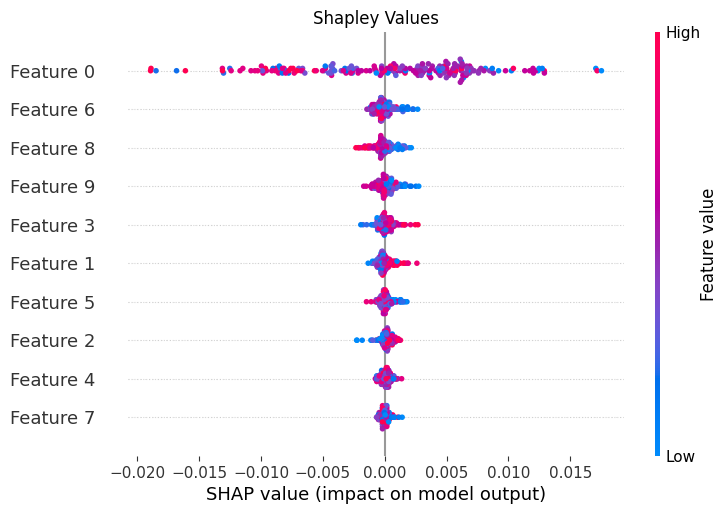

In [38]:
shap.plots.beeswarm(shap_values[:, :, 1], show = False)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Shapley Values')
plt.show()

### 4. Combining with Double Machine Learning

In [39]:
np.random.seed(42)
n_samples = 5000
n_features = 10
n_treatments = 3
n_outputs = 2
def true_te(X):
    return np.hstack(
        [(X[:, [0]] > 0) * X[:, [0]],
         np.ones((X.shape[0], n_treatments - 1)) * np.arange(1, n_treatments).reshape(1, -1)]
    )

In [40]:
X = np.random.normal(0, 1, size=(n_samples, n_features))
W = np.random.normal(0, 1, size=(n_samples, n_features))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))
for t in range(n_treatments):
    T[:, t] = np.random.binomial(1, scipy.special.expit(X[:, 0]))

In [41]:
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 5.0 * X[:, [0]] + np.random.normal(0, .1, size=(n_samples, 1))
y = np.tile(y, (1, n_outputs))
for j in range(n_outputs):
    y[:, j] = (j + 1) * y[:, j]
X_test = X[:min(100, n_samples)].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), min(100, n_samples))

In [42]:
causal_dml = CausalForestDML(
    cv = 2,
    criterion = 'mse',
    n_estimators = 400,
    min_var_fraction_leaf = 0.1,
    min_var_leaf_on_val = True,
    verbose = 0,
    discrete_treatment = False,
    n_jobs = -1,
    random_state = 42
)

In [43]:
causal_dml.fit(
    Y = y,
    T = T,
    X = X,
    W = W
)

In [44]:
res = causal_dml.const_marginal_effect_inference(X_test)
point = res.point_estimate
lb, ub = res.conf_int(alpha=.01)

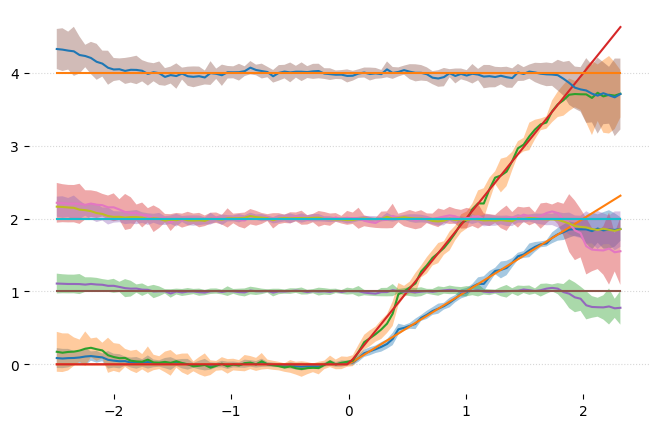

In [45]:
fig, ax = plt.subplots(figsize = (8, 5))
for t in range(n_treatments) :
    for j in range(n_outputs):
        ax.plot(X_test[:, 0], point[:, j, t])
        ax.fill_between(X_test[:, 0], lb[:, j, t], ub[:, j, t], alpha = 0.4)
        ax.plot(X_test[:, 0], (j + 1) * true_te(X_test)[:, t])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.show()

In [46]:
res.summary_frame()

point_estimate  stderr   zstat  pvalue  ci_lower  ci_upper
X  Y  T                                                             
0  Y0 T0           0.086   0.053   1.619   0.105    -0.018     0.190
      T1           1.109   0.053  20.954   0.000     1.005     1.212
      T2           2.164   0.053  40.517   0.000     2.059     2.269
   Y1 T0           0.172   0.106   1.619   0.105    -0.036     0.380
      T1           2.217   0.106  20.954   0.000     2.010     2.425
...                  ...     ...     ...     ...       ...       ...
99 Y0 T1           0.776   0.090   8.649   0.000     0.600     0.952
      T2           1.855   0.094  19.632   0.000     1.670     2.040
   Y1 T0           3.714   0.126  29.386   0.000     3.466     3.962
      T1           1.552   0.179   8.649   0.000     1.200     1.904
      T2           3.710   0.189  19.632   0.000     3.340     4.080

[600 rows x 6 columns]

In [47]:
res = causal_dml.effect_inference(
    X_test,
    T0 = np.zeros((X_test.shape[0], n_treatments)),
    T1 = np.ones((X_test.shape[0], n_treatments))
)
point = res.point_estimate
lb, ub = res.conf_int(alpha=0.01)

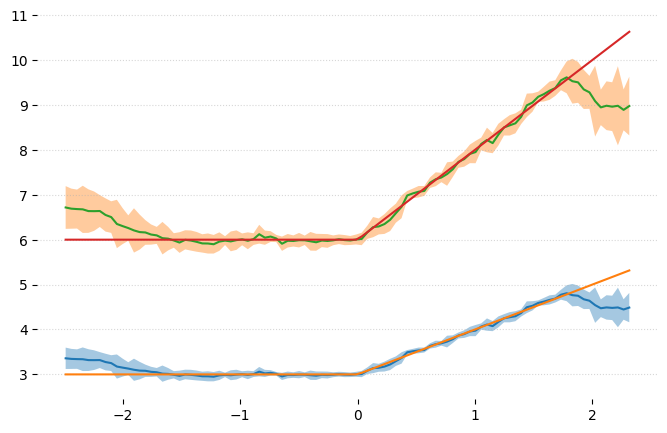

In [48]:
fig, ax = plt.subplots(figsize = (8, 5))

for j in range(n_outputs):
    ax.plot(X_test[:, 0], point[:, j])
    ax.fill_between(X_test[:, 0], lb[:, j], ub[:, j], alpha = 0.4)
    ax.plot(X_test[:, 0], (j + 1) * np.sum(true_te(X_test), axis=1))
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.show()

In [49]:
res.summary_frame()

point_estimate  stderr   zstat  pvalue  ci_lower  ci_upper
X  Y                                                             
0  Y0           3.359   0.092  36.354     0.0     3.177     3.540
   Y1           6.717   0.185  36.354     0.0     6.355     7.079
1  Y0           3.345   0.087  38.605     0.0     3.175     3.515
   Y1           6.690   0.173  38.605     0.0     6.351     7.030
2  Y0           3.341   0.084  39.699     0.0     3.176     3.506
...               ...     ...     ...     ...       ...       ...
97 Y1           8.982   0.342  26.280     0.0     8.312     9.651
98 Y0           4.445   0.088  50.235     0.0     4.272     4.619
   Y1           8.891   0.177  50.235     0.0     8.544     9.237
99 Y0           4.488   0.127  35.357     0.0     4.239     4.737
   Y1           8.976   0.254  35.357     0.0     8.478     9.474

[200 rows x 6 columns]

In [50]:
causal_dml.feature_importances_

array([[0.97946635, 0.00293155, 0.00174147, 0.00186799, 0.00264579,
        0.00194189, 0.00282688, 0.0013707 , 0.00401503, 0.00119236],
       [0.97946635, 0.00293155, 0.00174147, 0.00186799, 0.00264579,
        0.00194189, 0.00282688, 0.0013707 , 0.00401503, 0.00119236]])

In [51]:
causal_dml[0]

[GRFTree(max_features='auto', min_var_leaf=0.02068807856295478,
         min_var_leaf_on_val=True, random_state=1273642419),
 GRFTree(max_features='auto', min_var_leaf=0.02068807856295478,
         min_var_leaf_on_val=True, random_state=1273642419)]

### 5. Custom Linear Moment Forest

We can even easily create an estimator class that solves a customer linear moment that we want to define on the fly. The `BaseGRF` class can handle the estimation of any linear moment problem of the form:
\begin{equation}
E[\text{pointJ} \cdot (\theta(x); \beta(x)) - \alpha \mid X=x] = 0
\end{equation}

The user simply needs to create a child class that inherits from the `BaseGRF` and implement the abstract methods `_get_alpha_and_pointJ` and `_get_n_outputs_decomposition`. The first function takes as input all the variables passed at fit time (i.e. `X`, `T`, `y`, and any other keyword based variables the user passes) and returns for each sample the $\alpha$ vector of the linear moment and a flattened version of the $\text{pointJ}$ matrix in the linear moment (in Fortran contiguous form, i.e. the first row is first, the second row next etc). The second function returns two numbers, the first number corresponds to the size of the concatenated parameter vector $(\theta(x); \beta(x))$ and the second number corresponds to the size of the prefix $\theta(x)$ that we care about ($\beta(x)$ is a nuisance parameter).

As a simple expository example let's see how we can create a forest that solves a moment of the form:
\begin{equation}
E[(y - \theta(x)' (T; T^2)) (Z; Z^2) \mid X=x]
\end{equation}
i.e. where we expand the treatments and instruments to include their squares and solve this quadratic in treatment heterogenous IV model.

In [52]:
n_samples = 2000
n_features = 10
n_treatments = 2

def true_te(X):
    return np.hstack([X[:, [0]] > 0, np.ones((X.shape[0], n_treatments - 1))])

Z = np.random.normal(0, 1, size=(n_samples, n_treatments))
X = np.random.normal(0, 1, size=(n_samples, n_features))
U = np.random.normal(0, .2, size=(n_samples, 1))
T = np.random.normal(0, 1, size=(n_samples, n_treatments))

for t in range(n_treatments):
    T[:, t] += U[:, 0] + Z[:, t]
    
y = np.sum(true_te(X) * T, axis=1, keepdims=True) + 10 * U[:, [0]]
X_test = X[:1000].copy()
X_test[:, 0] = np.linspace(np.percentile(X[:, 0], 1), np.percentile(X[:, 0], 99), 1000)

In [53]:
from econml.grf._base_grf import BaseGRF
from econml.utilities import cross_product

class CustomGRF(BaseGRF):
    def _get_alpha_and_pointJ(self, X, T, y, *, Z):
        T = np.hstack([T, T**2])
        Z = np.hstack([Z, Z**2])
        if self.fit_intercept:
            T = np.hstack([T, np.ones((T.shape[0], 1))])
            Z = np.hstack([Z, np.ones((T.shape[0], 1))])
        return y * Z, cross_product(Z, T)

    def _get_n_outputs_decomposition(self, X, T, y, *, Z):
        n_relevant_outputs = T.shape[1] * 2
        n_outputs = n_relevant_outputs
        if self.fit_intercept:
            n_outputs += 1
        return n_outputs, n_relevant_outputs

In [54]:
est = CustomGRF(
    criterion = 'mse',
    n_estimators = 400,
    min_samples_leaf = 40,
    min_var_fraction_leaf = 0.1,
    min_var_leaf_on_val = True,
    min_impurity_decrease = 0.001, 
    max_samples = .45, 
    max_depth = None,
    warm_start = False, 
    inference = True, 
    subforest_size = 4,
    honest = True, 
    verbose = 0, 
    n_jobs = -1, 
    random_state = 42
)

In [56]:
est.fit(
    X = X, T = T, y = y, Z = Z
)

CustomGRF(min_impurity_decrease=0.001, min_samples_leaf=40,
          min_var_fraction_leaf=0.1, min_var_leaf_on_val=True, n_estimators=400,
          random_state=42)

In [57]:
point, lb, ub = est.predict(
    X_test, 
    interval = True, 
    alpha = 0.01
)

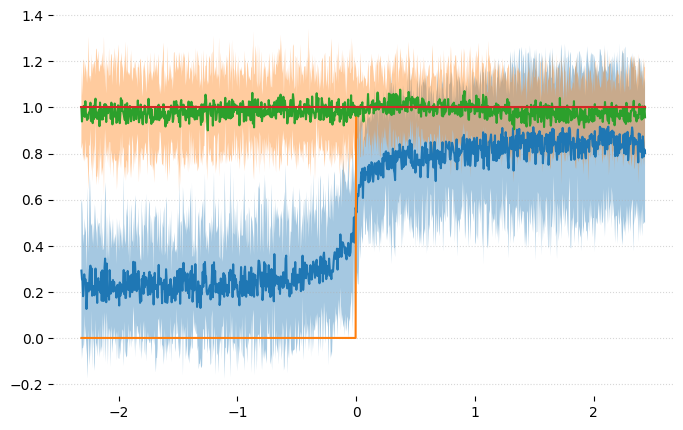

In [60]:
fig, ax = plt.subplots(figsize = (8, 5))

for t in range(n_outputs):
    ax.plot(X_test[:, 0], point[:, t])
    if est.inference :
        ax.fill_between(X_test[:, 0], lb[:, t], ub[:, t], alpha = 0.4)
    ax.plot(X_test[:, 0], true_te(X_test)[:, t])
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.show()

In [62]:
explainer = shap.Explainer(
    est, shap.maskers.Independent(
        X, 
        max_samples = 100
    )
)
shap_values = explainer(X[:200])

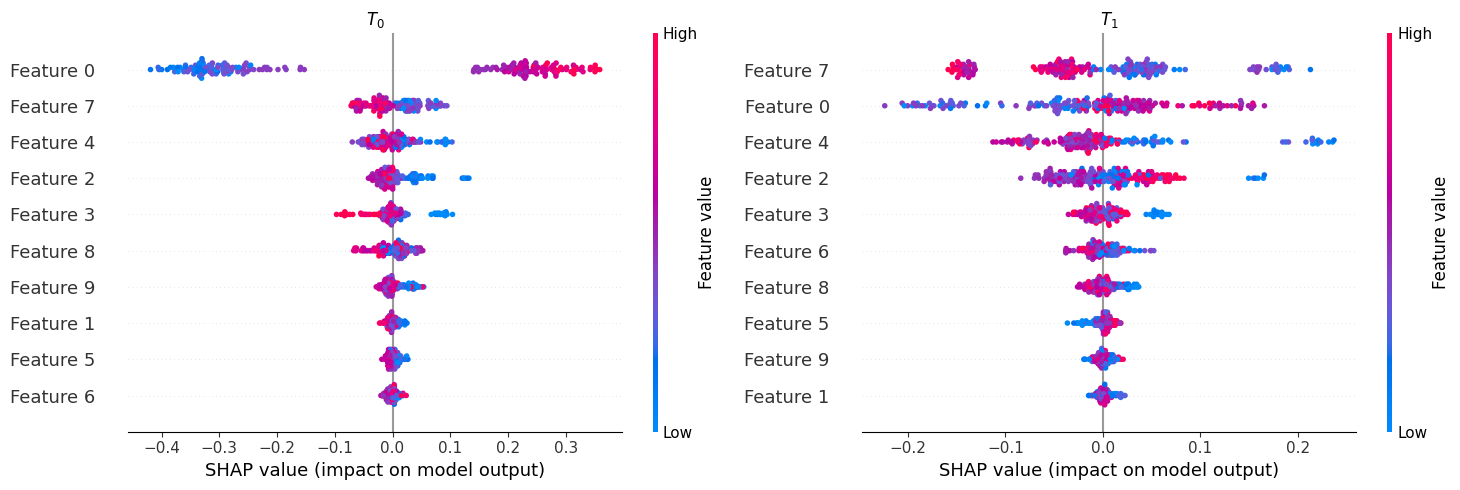

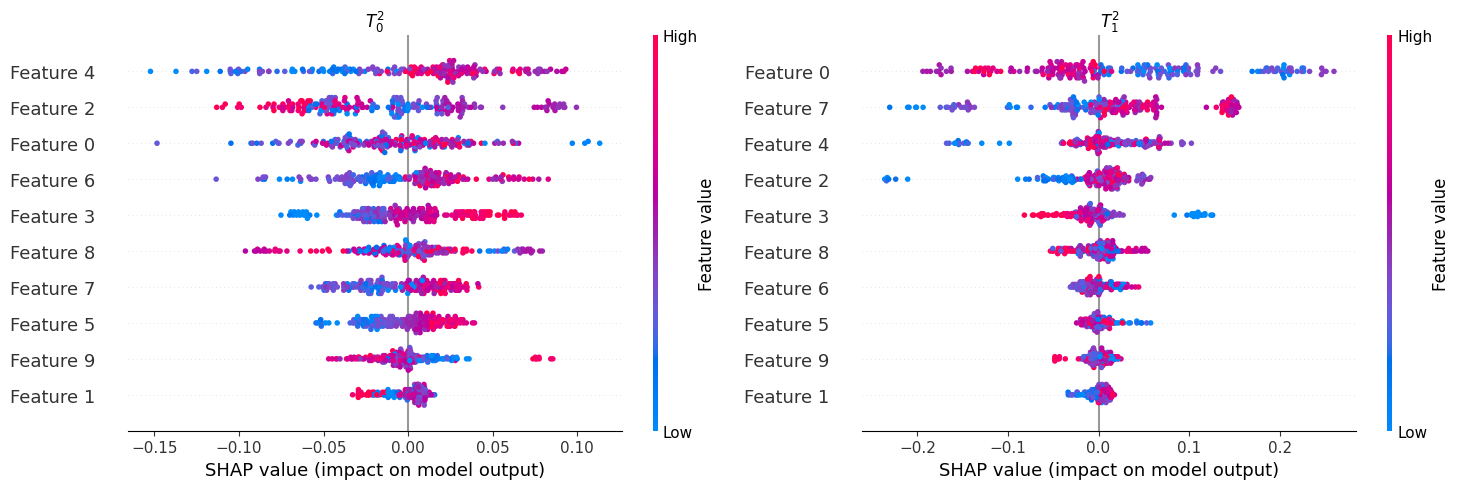

In [65]:
plt.figure(figsize=(15, 5))
for t in range(n_treatments):
    plt.subplot(1, n_treatments, t + 1)
    plt.title(r"$T_{}$".format(t))
    shap.plots.beeswarm(shap_values[..., t], plot_size=None, show=False)
plt.tight_layout()
plt.show()
plt.figure(figsize=(15, 5))
for t in range(n_treatments):
    plt.subplot(1, n_treatments, t + 1)
    plt.title(r"$T_{}^2$".format(t))
    shap.plots.beeswarm(shap_values[..., t + n_treatments], plot_size=None, show=False)
plt.tight_layout()
plt.show()